In [436]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx 
from shapely.geometry import Point, LineString
from shapely import distance
import numpy as np
from pyproj import Transformer
from shapely.geometry import LineString
import shapely.ops as sp_ops

In [437]:
main_folder_path =os.path.normpath(os.getcwd() + os.sep + os.pardir)
df =pd.read_csv(main_folder_path+"\\data\\_roads3.csv")

In [438]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

In [439]:
from shapely import buffer  

In [440]:
road_names =gdf["road"].unique()
road_names_N1= [road for road in road_names if road.startswith("N")]
# print(road_names)
line_dict = {}
line_dict_test = {}
for road_name in road_names_N1:
    # if road_name.startswith('N'):
    bridges_road = gdf[gdf["road"] == road_name]
        # bridges_road=bridges_road.sort_ values(by=['km'])
    if len(bridges_road["geometry"]) >= 2:
            line =LineString(bridges_road["geometry"])
            line_transformed = sp_ops.transform(transformer.transform ,line).length
            if line_transformed > 25000:
                line_dict[road_name] =buffer(LineString(bridges_road["geometry"]),0.008)
                line_dict_test[road_name] =line

gseries =gpd.GeoSeries(line_dict.values(), index=line_dict.keys(), crs=4326)
gseries_test =gpd.GeoSeries(line_dict_test.values(), index=line_dict_test.keys(), crs=4326)

In [441]:
# for index in gseries_test[gseries_test.index.isin(index_list)].index:
#     x=gseries_test[index]
#     # print(index)
#     line_transformed = sp_ops.transform(transformer.transform ,x).length
#     if line_transformed > 25000:
#         print(index,line_transformed)

In [442]:
# print(len(set(cross_index_N1)),len(cross_index_N1))
# print(len(set(cross_index_N2)),len(cross_index_N2))

In [443]:
cross_index_N1=[]
for index in gseries.index:
    if gseries["N1"].intersects(gseries[index]):
        cross_index_N1.append(index)
cross_index_N2=[]
for index in gseries.index:
    if gseries["N2"].intersects(gseries[index]):
        cross_index_N2.append(index)

intersecting_N1 =gseries[gseries.index.isin(cross_index_N1)]
intersecting_N2 =gseries[gseries.index.isin(cross_index_N2)]

intersections_N1 =gseries["N1"].intersection(intersecting_N1).drop("N1")
intersections_N2 =gseries["N2"].intersection(intersecting_N2).drop("N2")

gdf_N1 =gdf[gdf["road"]=="N1"]
gdf_N2 =gdf[gdf["road"]=="N2"]

In [444]:
print(list(gdf.columns).append("intersec_to"))

None


In [445]:
d=list(gdf.columns)+["intersec_to"]
d

['road',
 'chainage',
 'lrp',
 'lat',
 'lon',
 'gap',
 'type',
 'name',
 'geometry',
 'intersec_to']

In [446]:
print(d.append(1))


None


In [447]:
empty_dataframe = pd.DataFrame(columns=list(gdf.columns)+["intersec_to"])
empty_dataframe.columns

Index(['road', 'chainage', 'lrp', 'lat', 'lon', 'gap', 'type', 'name',
       'geometry', 'intersec_to'],
      dtype='object')

In [448]:
import warnings
warnings.filterwarnings("ignore")
def process_intersection_data(gdf_data, intersect_data):
    df_list = []
    index_list = []
    closest_points = []
    empty_dataframe = gpd.GeoDataFrame(columns=list(gdf.columns)+["intersec_to"],crs="EPSG:4326")

    for intersect_index_N1 in intersect_data.index:
        intersect_point_N1 = intersect_data[intersect_index_N1]
        min_dist = 10000

        for N1_index in gdf_data.index:
            N1_point = gdf_data.loc[N1_index, "geometry"]
            dist = distance(N1_point, intersect_point_N1)

            if dist < min_dist:
                min_dist = dist
                closest_point = N1_index
        series = gdf_data.loc[closest_point]
        series["intersec_to"]=intersect_index_N1    
        empty_dataframe.loc[closest_point]=series
        series =gdf_data.loc[closest_point]
        # print(series)
        # series["intersec_to"]=intersect_index_N1
        index_list.append(intersect_index_N1)
        closest_points.append(closest_point)
    
    
    # df_intersections_main = gdf_data[gdf_data.index.isin(closest_points)]
    # df_intersections_main["intersec_to"] = index_list
    # df_intersections_main["type"] = "intersection"
    
    # df_intersections_main = gdf_data[gdf_data.index.isin(closest_points)]
    # empty_dataframe["intersec_to"] = index_list
    empty_dataframe["type"] = "intersection"
    
    return empty_dataframe

# Process intersection data for gdf_N1
df_intersections_main_N1 = process_intersection_data(gdf_N1, intersections_N1)

# Process intersection data for gdf_N2
df_intersections_main_N2 = process_intersection_data(gdf_N2, intersections_N2)
df_intersections_main =pd.concat([df_intersections_main_N1,df_intersections_main_N2], axis=0, ignore_index=True)
df_intersections_main.to_csv(main_folder_path+"\\data\\intersections_main.csv")

In [449]:
df_intersections_main

,road,chainage,lrp,lat,lon,gap,type,name,geometry,intersec_to
0,N1,81.801,LRP083a,23.478944,91.117722,NaN,intersection,Box culvert,POINT (91.11772 23.47894),N102
1,N1,144.67,LRP147b,23.014083,91.375972,NaN,intersection,Box culvert,POINT (91.37597 23.01408),N104
2,N1,11.313,LRP011b,23.692277,90.541055,NaN,intersection,Box culvert,POINT (90.54106 23.69228),N105
3,N1,8.0,LRP008,23.702056,90.515722,NaN,intersection,Km post missing,POINT (90.51572 23.70206),N2
4,N1,0.0,LRPS,23.706028,90.443333,NaN,intersection,Start of Road after Jatrabari Flyover infront...,POINT (90.44333 23.70603),N8
5,N2,0.0,LRPS,23.705917,90.521444,NaN,intersection,Road Start from N1 at Katchpur,POINT (90.52144 23.70592),N1
6,N2,85.098,LRP085b,24.049694,91.107639,NaN,intersection,Box culvert,POINT (91.10764 24.04969),N102
7,N2,11.111,LRP011a,23.784805,90.565056,NaN,intersection,R202 to Rupganj,POINT (90.56506 23.78481),N105
8,N2,115.916,LRP117,24.146639,91.343055,NaN,intersection,Sylhet 115 km,POINT (91.34306 24.14664),N204
9,N2,145.322,LRP146a,24.290805,91.505528,NaN,intersection,Box culvert,POINT (91.50553 24.29081),N207


In [450]:
# df_list =[]
# df_list_test =[]
# index_list = []
# closest_points=[]
# for gdf_data, intersect_data in [[gdf_N1,intersections_N1],[gdf_N2,intersections_N2]]:
#     for intersect_index_N1 in intersect_data.index:
#         intersect_point_N1 =intersect_data[intersect_index_N1]
#         min_dist =10000    
#         for N1_index in gdf_data.index:
#             N1_pont =gdf_data.loc[N1_index,"geometry"]
#             dist =distance(gdf_data.loc[N1_index,"geometry"],intersect_point_N1)
#             if  dist< min_dist:
#                 min_dist = dist
#                 closest_point =N1_index
#         # print(intersect_index_N1,closest_point)
#         # print(closest_points)
#         index_list.append(intersect_index_N1)   
#         closest_points.append(closest_point)
#         
# # print(closest_points,index_list)
# df_intersections_main=gdf[gdf.index.isin(closest_points)]
# print(len(gdf[gdf.index.isin(closest_points)]))
# # df_list.append(gdf[gdf.index.isin(closest_points)])
# # df_intersections_main = pd.concat(df_list, axis=0, ignore_index=True)
# df_intersections_main["intersec_to"]=index_list
# df_intersections_main["type"] = "intersection"
# 
# 
# df_intersections_main.to_csv(main_folder_path+"\\data\\intersections_main.csv")

In [451]:
transformer =Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)

In [452]:
for index in gseries_test[gseries_test.index.isin(index_list)].index:
    x=gseries_test[index]
    # print(index)
    line_transformed = sp_ops.transform(transformer.transform ,x).length
    if line_transformed > 25000:
        print(index,line_transformed)

N1 490795.85069027985
N102 93488.49358724339
N104 53566.569719558305
N105 52537.755017801646
N2 312421.2499806181
N204 36868.5294876288
N207 72087.86336654497
N208 62573.57089209663


In [453]:
closest_points

[183,
 335,
 26,
 613,
 698,
 926,
 965,
 331,
 160,
 188,
 371,
 462,
 514,
 17,
 2346,
 2574,
 2364,
 2533,
 2661,
 3061,
 3079,
 2768,
 3069,
 3069,
 3100]

In [454]:
df_list = []
for road_name in intersections_N1.index:
    road_gdf = gdf[gdf["road"]==road_name]
    intersect_point_N1 =intersections_N1[road_name]
    min_dist=10000
    for road_point_index in road_gdf.index:
        road_point =road_gdf.loc[road_point_index,"geometry"]
        dist =distance(intersect_point_N1,road_point)
        if  dist< min_dist:
            min_dist = dist
            closest_point =road_point_index
    df_list.append(road_gdf[road_gdf.index == closest_point])
    
for road_name in intersections_N2.index:
    road_gdf = gdf[gdf["road"]==road_name]
    intersect_point_N2 =intersections_N2[road_name]
    min_dist=10000
    for road_point_index in road_gdf.index:
        road_point =road_gdf.loc[road_point_index,"geometry"]
        dist =distance(intersect_point_N2,road_point)
        if  dist< min_dist:
            min_dist = dist
            closest_point =road_point_index
    df_list.append(road_gdf[road_gdf.index == closest_point])  
    
df_intersections_side = pd.concat(df_list, axis=0, ignore_index=True)
df_intersections_side["type"]= "intersection"

df_intersections_side.to_csv(main_folder_path+"\\data\\intersections_side.csv")

In [455]:
1

1

In [456]:
gseries.index.isin(df_intersections_main["intersec_to"])

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False])

<Axes: >

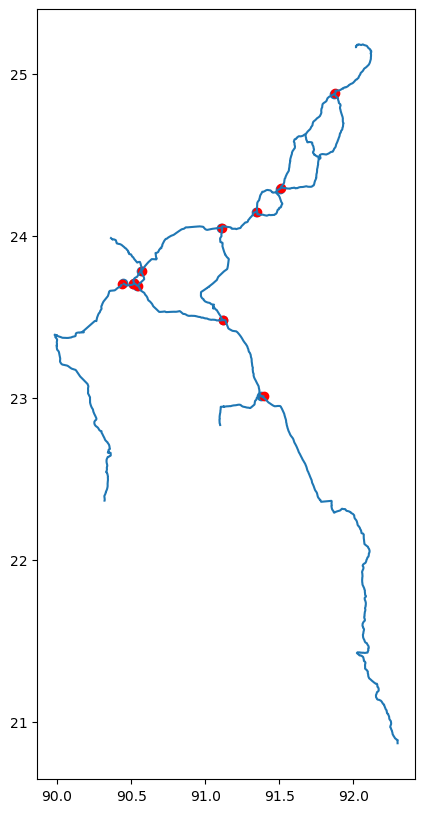

In [457]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
# Process intersection data for gdf_N1
df_intersections_main.plot(ax=ax)
gseries_test[gseries_test.index.isin(df_intersections_main["intersec_to"])].plot(ax=ax)
df_intersections_side.plot(ax=ax,color="red")
# Process intersection data for gdf_N2
# df_intersections_main_N2.plot(ax=ax)

In [458]:
gseries

N1      POLYGON ((90.44629 23.69599, 90.44012 23.69870...
N102    POLYGON ((90.96284 23.63596, 90.96289 23.63782...
N104    POLYGON ((91.08896 22.87589, 91.08884 22.87712...
N105    POLYGON ((90.36568 23.97301, 90.36167 23.97667...
N106    POLYGON ((91.81123 22.41655, 91.81124 22.41675...
N2      POLYGON ((90.51481 23.70123, 90.51387 23.70237...
N204    POLYGON ((91.34329 24.14068, 91.34280 24.14088...
N207    POLYGON ((91.50691 24.30252, 91.50706 24.30264...
N208    POLYGON ((91.76645 24.49106, 91.76603 24.49185...
N3      POLYGON ((90.36662 24.35055, 90.36660 24.35127...
N4      POLYGON ((89.91622 24.31830, 89.91632 24.31976...
N401    POLYGON ((90.02438 24.61516, 90.02445 24.61527...
N402    POLYGON ((90.16356 25.05129, 90.16413 25.05372...
N5      POLYGON ((88.34855 26.50978, 88.34815 26.51080...
N502    POLYGON ((88.99407 24.42428, 88.99640 24.43067...
N506    POLYGON ((89.25805 25.72287, 89.25805 25.72288...
N507    POLYGON ((89.09522 24.30552, 89.09816 24.30768...
N509    POLYGO

<Axes: >

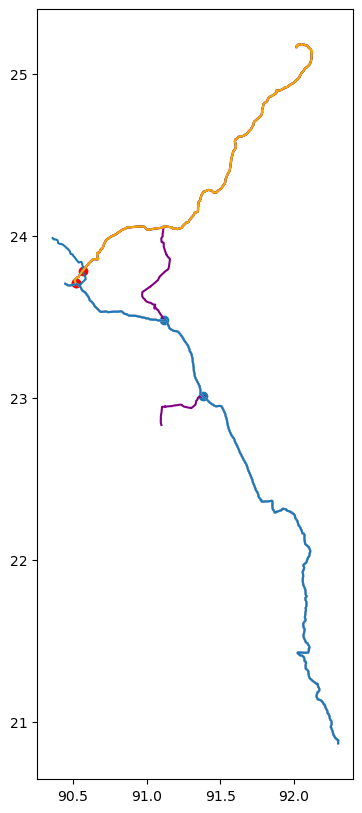

In [459]:


fig, ax = plt.subplots(1,1,figsize=(10,10))

Intersecting_1 =[line for line in gseries_test if gseries_test["N1"].intersects(line)]
intersections_1 =gseries_test["N1"].intersection(Intersecting_1)

# Intersecting =[line for line in gseries if gseries["N1"].intersects(line)]
# intersections =gseries["N1"].intersection(Intersecting)

# fig, ax = plt.subplots(1,1,figsize=(10,10))
gpd.GeoSeries(Intersecting_1, crs=4326).plot(ax=ax,color="purple")
gpd.GeoSeries(intersections_1, crs=4326).plot(ax=ax)
gpd.GeoSeries(gseries_test ["N1"],crs=4326).plot(ax=ax,color="white")




Intersecting =[line for line in gseries_test if gseries_test["N2"].intersects(line)]
intersections =gseries_test["N2"].intersection(Intersecting)


gpd.GeoSeries(intersections, crs=4326).plot(ax=ax,color="red")
gpd.GeoSeries(Intersecting, crs=4326).plot(ax=ax)
gpd.GeoSeries(gseries_test["N2"],crs=4326).plot(ax=ax,color="orange")

# gpd.GeoSeries(df_intersections["geometry"], crs=4326).plot(ax=ax,color="green")